In [2]:
import numpy as np 
import pandas as pd 
import os
import re
import statsmodels.api as sm
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import glob
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import plotly.graph_objs as go


In [3]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('DIV')[-1])
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [4]:
## read in data, div19_26uMbicucilin, 19_basal
lines_to_skip = 10 # adjust 

# count the number of header lines
firstTableHeading = "Mean Firing Rate (hz)"

FOLDER_PATH = f"{parent}/data/DATA for PCA for Pooja/" #
folder_dict = {}

CONTROL = 'unt2'
MUTANT = 'GPR37L 1'
## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath


folders = {key: folder_dict[key] for key in sorted(folder_dict.keys(), key=custom_sort)}

folders

{'DIV5': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV5',
 'DIV8': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV8',
 'DIV10': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV10',
 'DIV11': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV11',
 'DIV12': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV12',
 'DIV13': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV13',
 'DIV14': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV14',
 'DIV15': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV15',
 'DIV16': '/home/poojaparame

In [5]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            df['Subject'] = plate_key
            data_dict[plate_key] = df
    return data_dict
get_plates = {}

for day, folder in folders.items():
    get_plates[day] = read_csvs_to_dict(folder)
for day, files_dict in get_plates.items():
    print(files_dict.keys())

dict_keys(['plate_1', 'plate_3', 'plate_2'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_3', 'plate_1', 'plate_2'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_3', 'plate_2'])
dict_keys(['plate_3', 'plate_1', 'plate_2'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])
dict_keys(['plate_3', 'plate_2', 'plate_1'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])


In [6]:
def concat_plates(plates_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in plates_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value.drop(columns=['Subject']) for key, value in testparams_concat.items()}
    return testparams_concat

DIVS = {}
for day, plates in get_plates.items():
    DIVS[day] = concat_plates(plates, firstTableHeading)

DIVS.keys()

dict_keys(['DIV5', 'DIV8', 'DIV10', 'DIV11', 'DIV12', 'DIV13', 'DIV14', 'DIV15', 'DIV16', 'DIV17', 'DIV18', 'DIV19'])

In [7]:
def remove_mean_SEM(test_dict, day):
    for key, value in test_dict.items():
        to_drop = [index for index in ['B Mean', 'B SEM', 'B Std'] if index.casefold() in value.index.str.casefold()]
        if to_drop:
            test_dict[key] = value.drop(index=to_drop)
        test_dict[key].loc[:, 'DIV']=day
    return test_dict
for day, parameter_dict in DIVS.items():
    DIVS[day] = remove_mean_SEM(parameter_dict, day)

DIVS['DIV10'].keys()

dict_keys(['Mean Firing Rate (hz)', 'Number of Active Electrodes', 'Weighted Mean Firing Rate (Hz)', 'Number of Bursting Electrodes', 'Burst Frequency - Avg (Hz)', 'Burst Duration - Avg (s)', 'Normalized Duration IQR - Avg', 'IBI Coefficient of Variation - Avg', 'Burst Percentage - Avg', 'Network Burst Frequency (Hz)', 'Network Burst Duration - Avg (sec)', 'Network Burst Percentage', 'Network IBI Coefficient of Variation', 'Network Normalized Duration IQR', 'Area Under Normalized Cross-Correlation', 'Resistance - Avg (kOhms)', 'Number of Covered Electrodes'])

In [8]:
def rename_row_names(experiment_df):
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")

    experiment_df.index = [f"Replicate{i+1}" for i in range(len(experiment_df))]
    return experiment_df
for day, test_dict in DIVS.items():
    for test_name, df in test_dict.items():
        test_dict[test_name] = rename_row_names(df)
    DIVS[day] = test_dict
DIVS.keys()

dict_keys(['DIV5', 'DIV8', 'DIV10', 'DIV11', 'DIV12', 'DIV13', 'DIV14', 'DIV15', 'DIV16', 'DIV17', 'DIV18', 'DIV19'])

In [9]:
def impute_nans(table):
    days = table['DIV']
    table = table.drop(columns=['DIV'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)
    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['DIV'] = days
    return imputed_df

for day, tstdict in DIVS.items():
    for test, table in tstdict.items():
        tstdict[test] = impute_nans(table)
    DIVS[day] = tstdict

# # if nans in all columns, skip. need to remove chemtype and subject bc these will never have nans
# DIVSimp = {test_param: impute_nans(test_param, table) for test_param, table in DIVS.items() \
#     if not table.loc[:, ~(table.columns.isin(['Chemical_Type']))].isna().all().all()
# } 


**Lambdas for each feature are saved in `BC_LAMBDAS`**

With the following hierarchy:
`BC_LAMBDA` (dict)
|-> Test (meanfiringrate)
    all divs concatenated
    
    |-> lambda value

In [10]:
## now only take unt2
import copy
def keep_genes(DIVdf, gene):
    k = DIVdf[[gene]]
    return k.copy()

DIVSU =  {day: {} for day in DIVS.keys()}
DIVSM = {day: {} for day in DIVS.keys()}

for day, dct in DIVS.items():
    untdict = copy.deepcopy(dct) 
    mutdict = copy.deepcopy(dct)
    for (test), df in untdict.items():
        untdict[(test)]= keep_genes(df, CONTROL)
        mutdict[(test)] = keep_genes(df, MUTANT)
    DIVSU[day]=untdict
    DIVSM[day]=mutdict
DIVSU.keys()
DIVSM.keys()

dict_keys(['DIV5', 'DIV8', 'DIV10', 'DIV11', 'DIV12', 'DIV13', 'DIV14', 'DIV15', 'DIV16', 'DIV17', 'DIV18', 'DIV19'])

In [11]:
## histogram w all genes
# hdata = DIVS['DIV19']['Mean Firing Rate (hz)']
# plt.hist(hdata[['unt2']], bins=20, color=f'red', edgecolor='black')
# hdata

(array([3., 4., 0., 3., 1., 1., 1., 3., 2., 1., 0., 5., 2., 2., 3., 2., 1.,
        0., 1., 1.]),
 array([0.065461  , 0.09747535, 0.1294897 , 0.16150405, 0.1935184 ,
        0.22553275, 0.2575471 , 0.28956145, 0.3215758 , 0.35359015,
        0.3856045 , 0.41761885, 0.4496332 , 0.48164755, 0.5136619 ,
        0.54567625, 0.5776906 , 0.60970495, 0.6417193 , 0.67373365,
        0.705748  ]),
 <BarContainer object of 20 artists>)

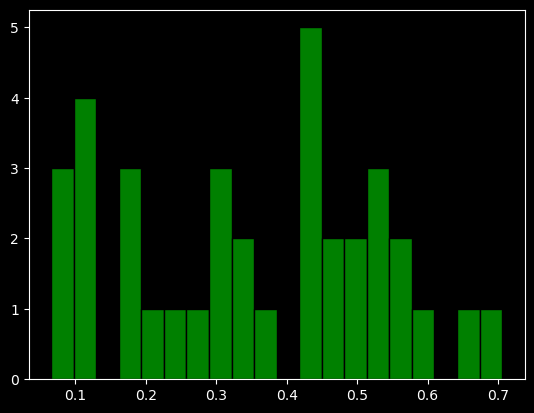

In [12]:
hdata = DIVSU['DIV5'][('Mean Firing Rate (hz)')]
plt.hist(hdata, bins=20, color=f'green', edgecolor='black')


In [13]:
## transform data int s x f
def transform_dict(daysDict, gene):
    sf = pd.DataFrame(columns=daysDict['DIV10'].keys())
    sf['DIV'] = int
    for day, testdct in tqdm(daysDict.items()):
        new_rowd= {k: list(d[[gene]].values.flatten()) for k,d in testdct.items()}
        new_rowd['DIV'] = [day]* len(list(testdct.values())[0][gene])
        lofd = []
        length = (len(next(iter(new_rowd.values()))))
        if length!= 36:
            print(new_rowd)
        for i in range(length):
            positionaldict = {key: value[i] for key, value in new_rowd.items()}
            lofd.append(positionaldict)
        smrow = pd.DataFrame(lofd)
        sf = pd.concat([sf, smrow], ignore_index=True)
    sf.reset_index(drop=True, inplace=True)
    return sf
sf = transform_dict(DIVSU, CONTROL)
mf = transform_dict(DIVSM, MUTANT)
sf

100%|██████████| 12/12 [00:00<00:00, 418.95it/s]


,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes,DIV
0,0.561301,6.0,0.736169,6.0,0.029747,0.234593,0.711902,1.050947,46.088488,0.023353,0.483063,60.178306,1.415529,0.350515,0.294919,38.147218,7.0,DIV5
1,0.564012,8.0,0.564012,8.0,0.024604,0.203513,0.542146,1.972837,77.754092,0.026689,0.317410,83.216266,2.238182,0.376812,0.577931,42.756379,8.0,DIV5
2,0.418057,5.0,0.666222,5.0,0.028691,0.232495,0.815116,0.711294,51.257545,0.023353,0.418074,63.042394,0.648333,0.493827,0.323032,38.896790,6.0,DIV5
3,0.525021,7.0,0.600024,7.0,0.026689,0.212352,0.720098,0.705657,70.892747,0.018349,0.590858,58.101668,0.739722,0.336000,0.344386,42.377527,7.0,DIV5
4,0.642827,7.0,0.723698,8.0,0.018140,0.248472,1.014907,0.794031,52.857241,0.010008,0.582107,42.912747,0.658743,0.091743,0.419073,41.521664,8.0,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.659138,8.0,1.659138,8.0,0.053743,0.235815,0.574510,4.728524,97.834243,0.045169,0.537769,99.873960,4.329987,0.746667,0.834162,42.925229,8.0,DIV19
428,0.734003,8.0,0.734003,8.0,0.015475,0.325415,0.518204,0.583986,90.883361,0.016729,0.476616,89.145299,0.619464,1.063291,0.846910,42.116889,8.0,DIV19
429,2.397742,8.0,2.397742,8.0,0.087829,0.342462,0.663808,2.338972,91.631227,0.026767,0.785745,62.855399,2.295133,0.251572,0.730128,40.034007,8.0,DIV19
430,7.098703,8.0,7.098703,8.0,0.162484,0.224156,0.604592,0.760791,97.763975,0.153910,0.430532,98.285512,0.720077,0.385542,0.883158,39.453970,8.0,DIV19


In [14]:
## remove outliers
def remove_outliers(df):
    days = df['DIV'].copy()
    dfo = df.drop(columns=['DIV'])
    dfo = dfo[(np.abs(stats.zscore(dfo)) < 3).all(axis=1)].copy()
    dfo['DIV'] = days.loc[dfo.index]
    return dfo, days
sfo, DIVSsf = remove_outliers(sf)
mfo, DIVSmf = remove_outliers(mf)

In [15]:
sfo.groupby(['DIV']).count()

,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes
DIV,,,,,,,,,,,,,,,,,
DIV10,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
DIV11,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
DIV12,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
DIV13,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
DIV14,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
DIV15,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
DIV16,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
DIV17,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
DIV18,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33


In [16]:
sfo

,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes,DIV
0,0.561301,6.0,0.736169,6.0,0.029747,0.234593,0.711902,1.050947,46.088488,0.023353,0.483063,60.178306,1.415529,0.350515,0.294919,38.147218,7.0,DIV5
1,0.564012,8.0,0.564012,8.0,0.024604,0.203513,0.542146,1.972837,77.754092,0.026689,0.317410,83.216266,2.238182,0.376812,0.577931,42.756379,8.0,DIV5
3,0.525021,7.0,0.600024,7.0,0.026689,0.212352,0.720098,0.705657,70.892747,0.018349,0.590858,58.101668,0.739722,0.336000,0.344386,42.377527,7.0,DIV5
4,0.642827,7.0,0.723698,8.0,0.018140,0.248472,1.014907,0.794031,52.857241,0.010008,0.582107,42.912747,0.658743,0.091743,0.419073,41.521664,8.0,DIV5
5,0.325897,6.0,0.422018,6.0,0.017793,0.173882,0.578798,1.295394,59.220622,0.015013,0.418098,75.111964,1.573953,0.275862,0.361567,42.235440,8.0,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.659138,8.0,1.659138,8.0,0.053743,0.235815,0.574510,4.728524,97.834243,0.045169,0.537769,99.873960,4.329987,0.746667,0.834162,42.925229,8.0,DIV19
428,0.734003,8.0,0.734003,8.0,0.015475,0.325415,0.518204,0.583986,90.883361,0.016729,0.476616,89.145299,0.619464,1.063291,0.846910,42.116889,8.0,DIV19
429,2.397742,8.0,2.397742,8.0,0.087829,0.342462,0.663808,2.338972,91.631227,0.026767,0.785745,62.855399,2.295133,0.251572,0.730128,40.034007,8.0,DIV19
430,7.098703,8.0,7.098703,8.0,0.162484,0.224156,0.604592,0.760791,97.763975,0.153910,0.430532,98.285512,0.720077,0.385542,0.883158,39.453970,8.0,DIV19


In [18]:
## box cox on each feature individually, all DIV
## box cox on all. looks good , more normally distributed on the histogram
def  box_cox(dr, lmbval =None): ## doing for each col. looks good. 
    original_shape, cols = dr.shape, dr.columns# Save the original shape
    dr = (dr.to_numpy().flatten())
    # print(dr <0)
    if np.any(dr <= 0):
        dr = dr + (1 - dr.min())
    if lmbval: # transforming
        bc_data = stats.boxcox(dr, lmbda=lmbval) # no lambda returned here
        fit_lambda = lmbval
    else:
        bc_data, fit_lambda = stats.boxcox(dr)
    bcdatar = np.reshape(bc_data, original_shape)
    bcdf = pd.DataFrame(bcdatar, columns=cols)
    return fit_lambda, bcdf

def log_n(value):
    out = np.log(1+ value)
    return out

def logx(value):
    out = np.log(value)
    return out

def normalize_data(dataf, BC_LAMBDAS=None):
    # if 'DIV' in dataf.columns:
    #     dataf.drop(columns='DIV', inplace=True)
    dataf.reset_index(drop=True, inplace=True)
    if not BC_LAMBDAS: # no lambdas, need to fit
        TOFIT = True
        BC_LAMBDAS = {feature: float for feature in dataf.columns if feature != 'DIV'}
    elif BC_LAMBDAS:
        TOFIT=False
    BC_sf = pd.DataFrame(index=dataf.index)
    notBC = ['Electrode', 'Resistance', 'Percentage', 'DIV']
    for col in dataf.columns:
        if not any(x.casefold() in col.casefold() for x in notBC):
            if TOFIT:
                lambd, df = box_cox(dataf[[col]])
                BC_LAMBDAS[col] = lambd
                BC_sf[col] = df[col]
            else:
                lambd, df = box_cox(dataf[[col]], BC_LAMBDAS[col])
                BC_LAMBDAS[col] = lambd
                BC_sf[col] = df[col]
        # elif 'Electrode'.casefold() in col.casefold():
        #     BC_sf[col] = sf[col].apply(log_n)
        #     BC_LAMBDAS[col] = 0
            # BC_sf[col] = sf[col]
        # elif 'Resistance'.casefold() in col.casefold() or 'Percentage'.casefold() in col.casefold():
        if 'Percentage'.casefold() in col.casefold():
            BC_sf[col] = dataf[col].apply(logx)
            BC_LAMBDAS[col] = 'logx'
    BC_sf = BC_sf.apply(pd.to_numeric, errors='coerce')
    BC_sf['DIV'] = dataf['DIV']

    return BC_sf, BC_LAMBDAS
    # else:
    #     BC_LAMBDAS[col] = 0
    #     BC_sf[col] = sf[col]
    
norm_sf, SFLAMBDAS = normalize_data(sfo)
norm_mf, _ = normalize_data(mfo, SFLAMBDAS)
# norm_mf
# BC_LAMBDAS
norm_sf

Mean Firing Rate (hz)
Weighted Mean Firing Rate (Hz)
Burst Frequency - Avg (Hz)
Burst Duration - Avg (s)
Normalized Duration IQR - Avg
IBI Coefficient of Variation - Avg
ppp
Network Burst Frequency (Hz)
Network Burst Duration - Avg (sec)
ppp
Network IBI Coefficient of Variation
Network Normalized Duration IQR
Area Under Normalized Cross-Correlation
Mean Firing Rate (hz)
Weighted Mean Firing Rate (Hz)
Burst Frequency - Avg (Hz)
Burst Duration - Avg (s)
Normalized Duration IQR - Avg
IBI Coefficient of Variation - Avg
ppp
Network Burst Frequency (Hz)
Network Burst Duration - Avg (sec)
ppp
Network IBI Coefficient of Variation
Network Normalized Duration IQR
Area Under Normalized Cross-Correlation


,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
0,-0.515217,-0.289512,-1.352043,-0.973415,-0.327021,0.049401,3.830563,-1.414310,-0.624623,4.097312,0.342868,0.273584,-0.278395,DIV5
1,-0.511395,-0.515860,-1.369001,-1.031221,-0.571524,0.627665,4.353551,-1.401914,-0.905426,4.421443,0.781039,0.289424,-0.241718,DIV5
2,-0.567455,-0.465248,-1.361997,-1.014435,-0.316411,-0.363409,4.261168,-1.434165,-0.470812,4.062194,-0.305029,0.264622,-0.275669,DIV5
3,-0.404768,-0.304711,-1.392102,-0.948620,0.014822,-0.237042,3.967595,-1.472357,-0.482670,3.759169,-0.424244,0.085377,-0.269187,DIV5
4,-0.902071,-0.738117,-1.393413,-1.089801,-0.514181,0.251049,4.081270,-1.448490,-0.726978,4.318980,0.445714,0.225730,-0.274454,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.561654,0.557044,-1.283007,-0.971208,-0.520742,1.300049,4.583275,-1.341236,-0.544365,4.603909,1.385436,0.469729,-0.133766,DIV19
355,-0.290748,-0.292140,-1.402401,-0.820290,-0.610621,-0.573606,4.509577,-1.440994,-0.634416,4.490268,-0.487894,0.580714,-0.125572,DIV19
356,1.048466,1.033310,-1.200814,-0.793609,-0.391256,0.769740,4.517772,-1.401631,-0.229024,4.140837,0.804623,0.209160,-0.189598,DIV19
357,2.985331,2.883338,-1.051364,-0.992457,-0.475486,-0.282433,4.582556,-1.087348,-0.706722,4.587877,-0.332610,0.294574,-0.100500,DIV19


In [70]:
## no need to transpose, sf yields fxf correlation
# fs = sf.transpose()
# fs.index
qc = pd.DataFrame(columns=norm_sf.columns, index=['min', 'max'])
for col in norm_sf.columns:
    qc.loc['min', col] = norm_sf[col].min()
    qc.loc['max', col] = norm_sf[col].max()
qc

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
min,-1.405465,-1.188319,-1.448366,-1.375398,-1.386865,-2.397351,3.510566,-1.490735,-1.386021,3.560462,-2.295142,0.0,-0.280292,DIV10
max,5.361038,5.083619,-0.584071,-0.527364,1.074232,1.303963,4.602834,-0.681069,0.133519,4.605076,1.385436,0.891723,-0.010779,DIV8


In [71]:
## drop for histograms
DIVS_SF = norm_sf['DIV']
norm_sf.drop(columns=['DIV'], inplace=True)

DIVS_MF = norm_mf['DIV']
norm_mf.drop(columns=['DIV'], inplace=True)

In [72]:
colors = list(matplotlib.colors.cnames.keys())

for i, col in enumerate(norm_sf.columns):
        valrange = norm_sf[col].max() - norm_sf[col].min()
        print(col , valrange)
        plt.figure(figsize=(10, 6)) 
        hdata = norm_sf[col].values  # Correct way to access column values
        color_index = i % len(colors)  # To cycle back to the start if you run out of unique colors
        plt.hist(hdata, bins=20, color=colors[color_index], edgecolor='black')
        plt.suptitle(f'BC normalization on each feature, ', fontsize=10)
        plt.title(f'{col}, lambda{SFLAMBDAS[col]}')
        SAVE_FILE = f'../plots/histograms/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'features/{col}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.xlabel('value range')
        plt.ylabel('frequency')
        plt.savefig(SAVE_FILE)
        # plt.show()
        plt.close()


Mean Firing Rate (hz) 6.766502333668901
Weighted Mean Firing Rate (Hz) 6.271938067524937
Burst Frequency - Avg (Hz) 0.8642949463120245
Burst Duration - Avg (s) 0.8480339560730633
Normalized Duration IQR - Avg 2.461096626289949
IBI Coefficient of Variation - Avg 3.7013134651422774
Burst Percentage - Avg 1.0922681535826664
Network Burst Frequency (Hz) 0.8096655724518713
Network Burst Duration - Avg (sec) 1.5195397311391396
Network Burst Percentage 1.0446142536663134
Network IBI Coefficient of Variation 3.6805783843491264
Network Normalized Duration IQR 0.8917234278056528
Area Under Normalized Cross-Correlation 0.2695135390676551


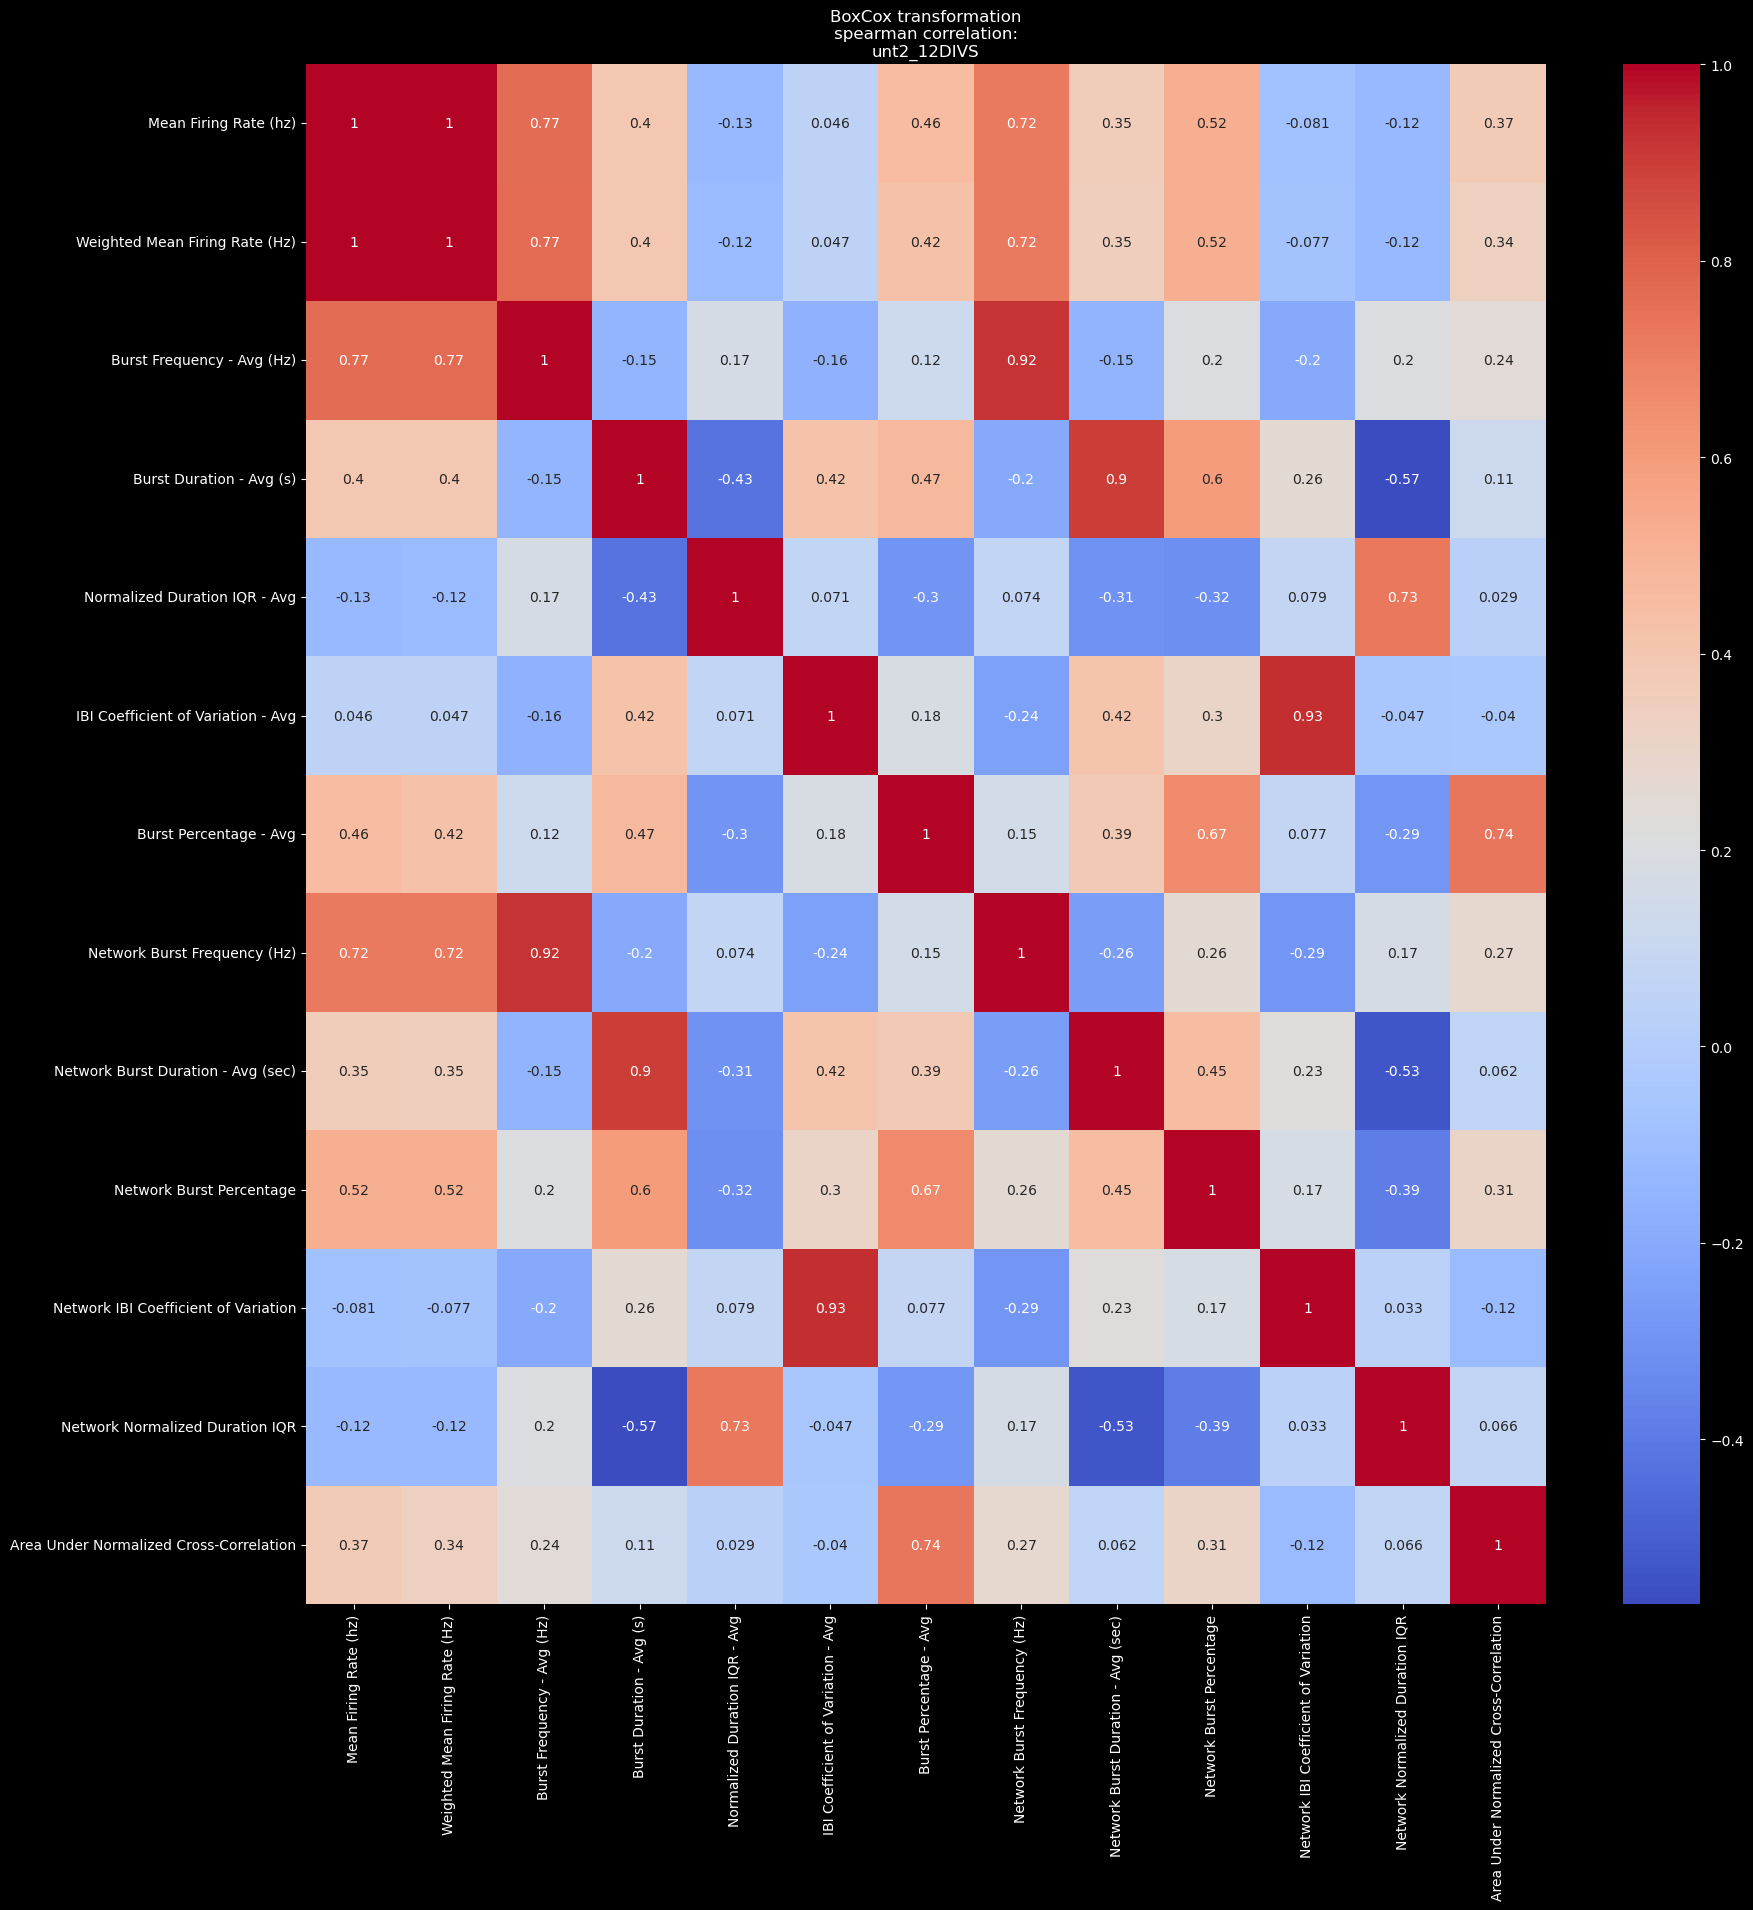

In [73]:
import seaborn as sns
type = 'spearman'
CORRS = (norm_sf.corr(method=type))
# print(CORRS)
# pearsonHM[key]= 
plt.figure(figsize=(20, 20))
ax = sns.heatmap(CORRS, annot=True, cmap='coolwarm')
plt.title(f'BoxCox transformation\n{type} correlation:\nunt2_12DIVS')
SAVE_FILE = f'../plots/heatmaps/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
            f'{type} Correlations.png'
ensure_dirs_exists(SAVE_FILE)
plt.savefig(SAVE_FILE)
plt.show()
# plt.close()

In [74]:
norm_mf

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation
0,-0.927624,-0.748201,-1.386164,-0.945140,-0.526406,-0.378129,4.084047,-1.456080,-0.520378,4.232473,-0.333181,-1.537870,-0.277209
1,-0.974118,-0.822445,-1.402028,-0.903020,0.016488,-0.439293,3.958485,-1.464011,-0.476375,4.161260,-0.466512,-4.888228,-0.278249
2,-0.566842,-0.348707,-1.388828,-0.974158,-0.103210,-0.151750,3.505299,-1.448490,-0.579481,3.826742,0.048703,-2.827149,-0.280124
3,-0.895982,-0.828054,-1.415469,-0.902236,-0.590724,-0.005120,4.153410,-1.481217,-0.382462,3.769215,-0.052903,-12.274898,-0.277180
4,-0.229400,-0.113505,-1.334169,-0.979612,-0.863539,0.146667,4.175790,-1.414310,-0.666220,3.944385,0.288244,-0.888997,-0.275414
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0.608268,0.602893,-1.354226,-0.722396,-1.170384,0.639851,4.567520,-1.401631,-0.108430,4.534129,0.626930,-1.203824,-0.147346
368,2.142482,2.085920,-1.152258,-0.851454,-0.049825,1.028609,4.593422,-1.263202,-0.364366,4.599845,0.923432,-1.475598,-0.114936
369,0.866652,0.856077,-1.334036,-0.664053,-0.701170,0.441470,4.568483,-1.389754,-0.117713,4.596682,0.340947,-1.055076,-0.190674
370,1.124661,1.107372,-1.324098,-0.676276,-0.174657,0.268190,4.510346,-1.395630,-0.001385,4.366291,0.175005,-2.936998,-0.171832


In [39]:
# remove DIV5
def remove_DIV(dataf, daysf, day):
    """Map all og days back to df. 
    Get df without day of choice.
    return df WITHOUT day. And corresponding days without tht day

    Args:
        dataf (df): _description_
        daysf (_type_): _description_
        day (_type_): _description_
    """
    dataf = dataf.copy(deep=True)
    dataf['DIV'] = daysf.loc[dataf.index]
    rem_data = dataf[dataf['DIV'] == day.upper()].copy()
    cut_dataf = dataf[dataf['DIV'] != day.upper()].copy()
    cut_days = daysf.loc[cut_dataf.index]
    cut_dataf = cut_dataf.drop(columns='DIV').reset_index(drop=True)
    cut_days = cut_days.drop(columns='DIV').reset_index(drop=True)
    return cut_dataf, cut_days, rem_data
norm_sf5, DIVS_SF5, DROPPED_DAYS = remove_DIV(norm_sf, DIVS_SF, 'DIV5')
norm_mf5, DIVS_MF5, DROPPED_DAYSM= remove_DIV(norm_mf, DIVS_MF, 'DIV5')
DROPPED_DAYS

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
0,-0.515217,-0.289512,-1.352043,-0.973415,-0.327021,0.049401,3.830563,-1.414310,-0.624623,4.097312,0.342868,0.273584,-0.278395,DIV5
1,-0.511395,-0.515860,-1.369001,-1.031221,-0.571524,0.627665,4.353551,-1.401914,-0.905426,4.421443,0.781039,0.289424,-0.241718,DIV5
2,-0.567455,-0.465248,-1.361997,-1.014435,-0.316411,-0.363409,4.261168,-1.434165,-0.470812,4.062194,-0.305029,0.264622,-0.275669,DIV5
3,-0.404768,-0.304711,-1.392102,-0.948620,0.014822,-0.237042,3.967595,-1.472357,-0.482670,3.759169,-0.424244,0.085377,-0.269187,DIV5
4,-0.902071,-0.738117,-1.393413,-1.089801,-0.514181,0.251049,4.081270,-1.448490,-0.726978,4.318980,0.445714,0.225730,-0.274454,DIV5
5,-0.465808,-0.226866,-1.359246,-1.081012,-0.413783,0.069254,4.054259,-1.434165,-0.736556,3.782823,0.219004,0.320212,-0.276532,DIV5
6,-0.955954,-0.670137,-1.421851,-1.033226,-0.594756,-0.102804,3.948000,-1.481217,-0.767808,3.745476,-0.058923,0.372103,-0.279899,DIV5
7,-0.914359,-0.759836,-1.402346,-0.861135,-0.817840,-0.417197,4.107779,-1.456080,-0.417390,4.207502,-0.390080,0.045493,-0.272908,DIV5
8,-1.405465,-1.188319,-1.448366,-0.999521,-1.386865,-0.220266,4.099283,-1.490735,-0.740124,4.020364,-0.426481,0.000000,-0.273673,DIV5
9,-0.699412,-0.357656,-1.405282,-1.012506,-0.022903,-0.313879,3.896823,-1.472527,-0.468770,3.725534,-0.464169,0.112577,-0.277137,DIV5


In [60]:
## PCA on BC and log
## initial PCA on unt2, div5 included or not. ur choice. c
plt.figure(figsize=(10, 6))

DATA, DAYS, OGTYPE  = norm_sf, DIVS_SF, 'allDIVS' # CHANGE HERE
if 'DIV' in DATA.columns:
    DATA.drop(columns='DIV', inplace=True)
pca = PCA(n_components=DATA.shape[1])
principalComponent = pca.fit_transform(DATA) ## CHANGE DATASET

## u want to flip any loading?
# modified_loadings = pca.components_.copy() ## each array is a PC. 13 inner most arrays are taht PC vals for all features.
# modified_loadings[2] *= -1
# # pca.components_
# mod_prinComp = DATA.dot(modified_loadings.T) # data rxf, loadings pc x f. need transpose so r x pc 
# mod_prinComp
# convert principalComponent np array to df 
pca_df = pd.DataFrame(data = principalComponent, columns = [f'PC{i}' for i in range(1, DATA.shape[1]+1)])
assert(DATA.shape[0] == DAYS.shape[0])
pca_df['DIV'] = DAYS

# ## avg all replicates for each DIV along test
pca_avg = pca_df.groupby('DIV', as_index=False).mean()
# modified_loadings.T 
pca_avg

,DIV,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,DIV10,0.755998,0.465480,-0.476775,-0.258037,-0.007661,0.021035,-0.000374,-0.015346,-0.006381,-0.007332,-0.013021,0.007893,-0.000336
1,DIV11,0.049140,0.598667,-0.489334,-0.022827,-0.101455,-0.002656,0.047818,0.023396,0.002562,-0.009929,-0.007269,0.019224,-0.012579
2,DIV12,-0.635567,0.309577,0.035135,0.086607,-0.045453,0.001827,-0.002383,0.001597,0.013715,0.010691,-0.012227,0.015226,-0.007864
3,DIV13,-1.732344,0.470380,0.323301,-0.031560,0.005486,0.009068,-0.029893,0.015125,0.015110,-0.009331,0.008063,-0.002372,-0.006375
4,DIV14,-1.969798,-0.108702,-0.117915,0.213333,0.042300,-0.001990,0.082381,-0.009516,-0.016907,-0.022900,0.007253,-0.005369,0.013763
5,DIV15,-1.365288,-0.601765,0.014389,0.035322,0.033630,0.004823,0.013104,-0.011289,0.050153,0.011642,-0.006797,0.006683,0.004141
6,DIV16,-0.836280,-0.837483,0.216304,-0.052278,-0.018356,0.005203,-0.047788,-0.022630,0.015819,0.007186,-0.011672,0.003387,-0.006345
7,DIV17,-0.027306,-0.382665,0.403608,0.077130,-0.074133,0.048088,-0.034578,0.018728,-0.032985,0.008340,0.007967,-0.005718,0.000742
8,DIV18,0.972254,-0.593893,0.153334,0.038042,-0.118275,-0.017621,0.007105,0.029716,-0.002102,0.000741,0.006807,-0.018745,0.006490
9,DIV19,0.745728,-0.452614,0.286139,0.138783,-0.099985,-0.025192,-0.014936,0.030940,-0.021254,0.007089,0.011263,-0.006937,0.002174


<Figure size 1000x600 with 0 Axes>

In [43]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,DIV
0,-1.447565,0.695932,-0.416465,-0.234857,0.111992,-0.038934,-0.015453,-0.129939,-0.007118,0.032353,0.064886,-0.011304,0.035578,DIV8
1,-1.431696,0.432349,-0.780352,0.065633,-0.061021,-0.128274,0.026610,0.004409,-0.051795,-0.031179,0.010180,-0.010054,-0.005727,DIV8
2,-1.750041,0.462471,-0.530326,0.221447,0.059480,-0.083947,0.061398,0.157409,-0.015899,0.020973,-0.042470,-0.030745,0.016573,DIV8
3,-0.172108,1.140816,-0.627056,-0.250434,-0.189684,-0.037836,-0.050816,-0.006941,0.030591,-0.000660,0.066676,0.032313,0.005148,DIV8
4,-0.513565,0.759126,-0.886170,-0.170173,-0.223703,-0.053003,-0.014330,0.002160,-0.021600,-0.006966,0.055094,0.000196,-0.001676,DIV8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,-2.450206,-1.713606,0.640029,-0.191861,-0.134125,-0.049272,0.115499,-0.044138,0.079739,0.032803,-0.011145,0.001189,0.011312,DIV19
340,-3.496488,0.954261,0.881629,0.221859,-0.050642,-0.292160,0.180760,0.058580,0.005155,-0.097279,0.113228,0.031039,0.024634,DIV19
341,-1.717110,-1.021446,0.656728,0.206994,0.350711,0.015825,-0.084561,-0.210330,0.007173,0.014681,0.182068,-0.025603,-0.050386,DIV19
342,1.022460,0.449425,0.311215,-0.145017,-0.063273,-0.059533,-0.082121,-0.035639,-0.076627,0.022392,-0.063654,-0.025268,0.000537,DIV19


In [44]:
loadings = pd.DataFrame(pca.components_ * np.sqrt(pca.explained_variance_), columns=DATA.columns, index=[f'PC{i}' for i in range(1, len(pca.components_) + 1)])
LOADINGSFILE = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/weights/{OGTYPE}_unt2_pcaloadings.csv'
ensure_dirs_exists(LOADINGSFILE)
loadings.to_csv(LOADINGSFILE)
loadings

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation
PC1,1.158068,0.654669,0.037381,0.015013,-0.008770,-0.002449,0.002711,0.006116,0.005695,0.001847,-0.002431,-0.000748,0.000209
PC2,-0.054913,-0.036548,0.012503,-0.024713,-0.007451,-0.078151,-0.002059,0.003685,-0.009635,-0.001757,-0.027405,0.000102,0.000079
PC3,-0.092945,-0.066252,-0.062416,0.068429,-0.127769,0.000131,0.007877,-0.008429,0.023574,0.004393,-0.001680,-0.007895,-0.000013
PC4,-0.041778,-0.042374,-0.068123,0.090989,0.069975,0.010948,0.008035,-0.017879,0.049954,0.004547,-0.011910,-0.001724,0.000270
PC5,-0.117769,0.134092,0.005522,-0.010288,-0.004481,-0.022586,-0.054686,-0.016954,0.017201,-0.031584,0.006811,-0.000364,-0.004400
PC6,-0.110042,0.024444,0.115888,-0.056906,-0.001040,0.067012,-0.030846,0.018172,-0.006950,-0.003279,-0.018089,-0.012536,-0.003366
PC7,0.045315,-0.031048,-0.001804,-0.004048,-0.037010,0.038892,-0.011798,-0.002542,0.004822,-0.002431,-0.011529,0.024310,-0.000939
PC8,-0.688670,0.406761,-0.032246,0.098237,0.003942,-0.013563,-0.043173,0.016959,-0.003524,0.021666,0.002894,0.002510,-0.006357
PC9,0.038186,-0.146126,0.237998,-0.132123,-0.006015,-0.021954,0.000578,0.043071,0.033212,0.007785,0.006558,0.002714,-0.003748
PC10,-0.816899,0.528790,0.022751,-0.140204,-0.006085,0.007077,0.040708,-0.019285,0.007225,-0.004223,-0.001849,0.000503,0.003793


In [45]:
loadings = pd.DataFrame(pca.components_, columns=DATA.columns, index=[f'PC{i}' for i in range(1, len(pca.components_) + 1)])
loadings.T.iloc[:, :4]

,PC1,PC2,PC3,PC4
Mean Firing Rate (hz),0.714519,-0.033881,-0.057346,-0.025776
Weighted Mean Firing Rate (Hz),0.677893,-0.037845,-0.068602,-0.043877
Burst Frequency - Avg (Hz),0.074234,0.024830,-0.123952,-0.135287
Burst Duration - Avg (s),0.046738,-0.076937,0.213033,0.283267
Normalized Duration IQR - Avg,-0.058018,-0.049293,-0.845246,0.462913
IBI Coefficient of Variation - Avg,-0.021090,-0.672887,0.001124,0.094264
Burst Percentage - Avg,0.026221,-0.019918,0.076203,0.077729
Network Burst Frequency (Hz),0.067035,0.040383,-0.092386,-0.195949
Network Burst Duration - Avg (sec),0.082247,-0.139158,0.340468,0.721449
Network Burst Percentage,0.041034,-0.039035,0.097600,0.101032


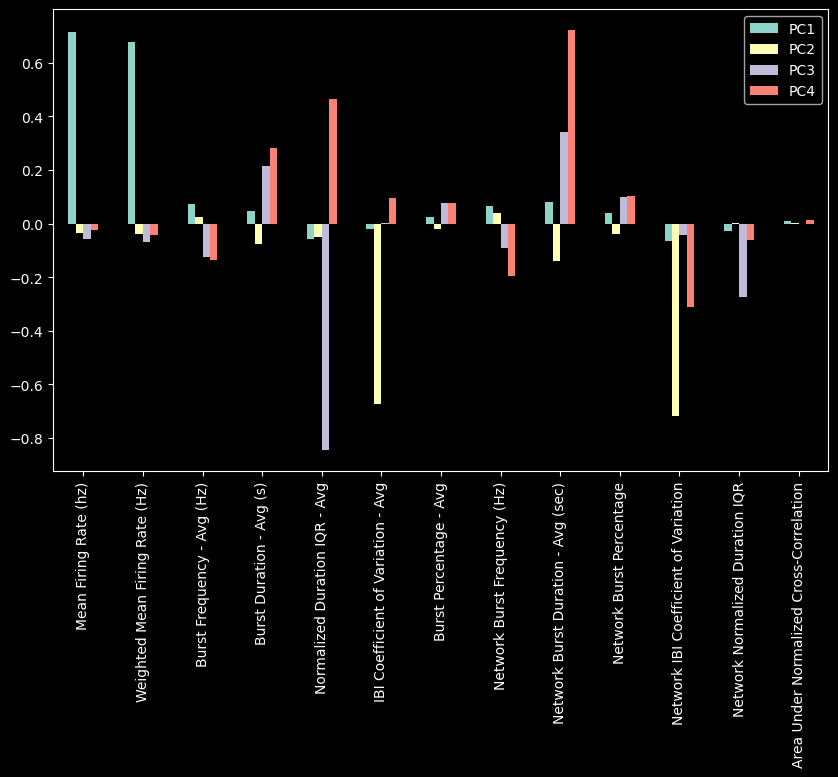

In [46]:
loadings.T.iloc[:, :4].plot(kind='bar' ,figsize=(10, 6))
plt.savefig(f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/weights/{OGTYPE}_unt2_compsVfeat.png')
plt.show()

In [47]:
DROPPED_DAYS

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
0,-0.515217,-0.289512,-1.352043,-0.973415,-0.327021,0.049401,3.830563,-1.414310,-0.624623,4.097312,0.342868,0.273584,-0.278395,DIV5
1,-0.511395,-0.515860,-1.369001,-1.031221,-0.571524,0.627665,4.353551,-1.401914,-0.905426,4.421443,0.781039,0.289424,-0.241718,DIV5
2,-0.567455,-0.465248,-1.361997,-1.014435,-0.316411,-0.363409,4.261168,-1.434165,-0.470812,4.062194,-0.305029,0.264622,-0.275669,DIV5
3,-0.404768,-0.304711,-1.392102,-0.948620,0.014822,-0.237042,3.967595,-1.472357,-0.482670,3.759169,-0.424244,0.085377,-0.269187,DIV5
4,-0.902071,-0.738117,-1.393413,-1.089801,-0.514181,0.251049,4.081270,-1.448490,-0.726978,4.318980,0.445714,0.225730,-0.274454,DIV5
5,-0.465808,-0.226866,-1.359246,-1.081012,-0.413783,0.069254,4.054259,-1.434165,-0.736556,3.782823,0.219004,0.320212,-0.276532,DIV5
6,-0.955954,-0.670137,-1.421851,-1.033226,-0.594756,-0.102804,3.948000,-1.481217,-0.767808,3.745476,-0.058923,0.372103,-0.279899,DIV5
7,-0.914359,-0.759836,-1.402346,-0.861135,-0.817840,-0.417197,4.107779,-1.456080,-0.417390,4.207502,-0.390080,0.045493,-0.272908,DIV5
8,-1.405465,-1.188319,-1.448366,-0.999521,-1.386865,-0.220266,4.099283,-1.490735,-0.740124,4.020364,-0.426481,0.000000,-0.273673,DIV5
9,-0.699412,-0.357656,-1.405282,-1.012506,-0.022903,-0.313879,3.896823,-1.472527,-0.468770,3.725534,-0.464169,0.112577,-0.277137,DIV5


In [62]:
### fit to any new data?
MDATA, MDAYS, MTYPE  = norm_mf, DIVS_MF, 'allMutDays' # CHANGE HERE
mprincipalComponent = pca.transform(MDATA) ## CHANGE DATASET

# convert principalComponent np array to df
mpca_df = pd.DataFrame(data = mprincipalComponent, columns = [f'PC{i}' for i in range(1, MDATA.shape[1]+1)])
mpca_df['DIV'] = DIVS_MF

mpca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,DIV
0,4.180731,0.646887,1.212408,0.383012,0.367842,0.769043,-1.491256,-0.033367,-0.056476,-0.085770,-0.092375,-0.023636,0.062774,DIV5
1,4.255994,0.764052,1.746353,0.939626,0.829543,2.281350,-4.353812,-0.331976,-0.403644,-0.171560,-0.304003,-0.073791,0.086361,DIV5
2,3.721675,0.228405,1.125138,0.432353,1.203557,1.363498,-2.610671,-0.090533,-0.285874,-0.251843,-0.293675,0.062149,0.064695,DIV5
3,4.175786,0.245311,4.399788,1.131354,1.745399,5.477716,-10.292923,-1.423138,-1.090083,-0.033532,-0.617056,-0.262546,0.039371,DIV5
4,3.289494,-0.122098,1.176129,-0.146500,0.510943,0.461810,-0.889647,-0.213019,-0.107618,-0.012266,0.021363,-0.050550,-0.020030,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,2.110550,-0.825575,1.780116,0.175152,0.002348,0.517595,-1.069303,-0.182709,-0.026254,0.013618,-0.035338,-0.003508,0.009721,DIV19
368,0.025261,-1.370319,0.672150,0.300916,0.098471,0.805651,-1.560728,-0.232080,-0.208678,0.022033,-0.134625,-0.045832,0.022488,DIV19
369,1.743759,-0.529827,1.343890,0.445941,-0.033361,0.479016,-1.045218,-0.095525,-0.073524,-0.030272,-0.011535,-0.056573,0.013591,DIV19
370,1.388227,-0.328810,1.454235,0.899611,0.403586,1.253381,-2.711454,-0.368745,-0.270003,-0.019829,-0.113189,-0.072922,-0.019265,DIV19


In [63]:

exp_variance = pca.explained_variance_ratio_
exp_variance = {f'PC{i+1}': ev for i, ev in enumerate(exp_variance)}
# with open('plots/PCA/BoxCox&Log/DATA for PCA for Pooja/explained_variances.txt', 'a') as f:
#     f.write(exp_variance)
exp_variance

{'PC1': 0.7000322081246134,
 'PC2': 0.2004115368036632,
 'PC3': 0.059245905851913,
 'PC4': 0.022476094420002507,
 'PC5': 0.008260450528327145,
 'PC6': 0.0030765815348821816,
 'PC7': 0.002350343732584317,
 'PC8': 0.0018600461753661085,
 'PC9': 0.0010681158098303821,
 'PC10': 0.0004951524021193675,
 'PC11': 0.0003570066833646287,
 'PC12': 0.00022204086735826614,
 'PC13': 0.00014451706597532344}

In [64]:
def get_color(color_list):
    for color in color_list:
        yield color
# colors = list(mcolors.CSS4_COLORS.values())[:17]  # Get the first 17 colors from the CSS4_COLORS dictionary
colors = [
    '#801919', '#a85e32', '#25e8cb', '#e6f518',  '#eb8383', '#69f518', '#234f09',  '#205ae3', '#6799bf', '#583cb5','#b688eb','#4e1066',  
    '#ec3dff', '#451541', '#fc1e1e', '#690d0d','#000000', '#FFD700', '#C0C0C0',  '#008B8B', '#B8860B', '#B22222',  '#556B2F', '#7FFF00',  # Chartreuse
    '#D2691E'   # Chocolate
]
xa = 'PC12'
ya = 'PC13'
PCADATA, TYPE = pca_avg, f'Control: ({CONTROL}), avg'

assign_color = get_color(colors)
color_map = {div_value: next(assign_color) for div_value in pca_df['DIV'].unique()}
# color_map.update({div_value: next(assign_color) for div_value in mpca_df['DIV'].unique() if div_value not in color_map})

if OGTYPE.casefold() != 'allDIVs'.casefold():
    ## add back in DIV5. just transform
    remdays = DROPPED_DAYS['DIV']
    pca_dd = pca.transform(DROPPED_DAYS.drop(columns='DIV')) ## CHANGE DATASET
    pca_dd = pd.DataFrame(data = pca_dd, columns = [f'PC{i}' for i in range(1, DROPPED_DAYS.shape[1])])
    pca_dd['DIV'] = remdays.values

    if 'avg'.casefold() in TYPE.casefold():
        pca_dd = pca_dd.groupby('DIV', as_index=False).mean()

    PCADATA = pd.concat([PCADATA, pca_dd], axis = 0).reset_index(drop=True)

fig = px.scatter(PCADATA, x=xa, y=ya, color='DIV', 
                 title=f'{OGTYPE} PCA {TYPE} ',
                 color_discrete_map=color_map, size_max=10, size=[10]*len(PCADATA),
                 width=1200, height=500)

fig.add_annotation(x=max(PCADATA[xa]), y=min(PCADATA[ya]),
                   text=f'{xa} explained variance: {exp_variance[xa]*100:.2f}%', 
                   showarrow=False, arrowhead=1,
                   bgcolor='rgba(255, 0, 0, 0.5)',
                   yshift=10,
                   xanchor='right', yanchor='bottom')

fig.add_annotation(x=min(PCADATA[xa]), y=max(PCADATA[ya]),
                   text=f'{ya} explained variance: {exp_variance[ya]*100:.2f}%', 
                   showarrow=False, arrowhead=1, 
                   xanchor='left', yanchor='middle',bgcolor='rgba(255, 0, 0, 0.5)'
                  )

# for div_value in mpca_df['DIV'].unique():
#     mutDIVdf = mpca_df[mpca_df['DIV'] == div_value]
#     fig.add_trace(go.Scatter(
#         x=mutDIVdf[xa], 
#         y=mutDIVdf[ya],
#         mode='markers',
#         marker=dict(
#             color=color_map[div_value],
#             size=10,                    
#             line=dict(                 
#                 color='black',        
#                 width=2     
#             )
#         ),
#         name=div_value
#     ))

plot_file = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/png/{OGTYPE}/'\
                f'{xa}_{ya}_{TYPE}.png'

ensure_dirs_exists(plot_file)
plot_html = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/htmls/{OGTYPE}/'\
                f'{xa}_{ya}_{TYPE}.html'

ensure_dirs_exists(plot_html)
fig.write_html(plot_html)
fig.write_image(plot_file)
fig.show()


In [32]:
mpca_df['DIV'].unique()

array(['DIV5', 'DIV8', 'DIV10', 'DIV11', 'DIV12', 'DIV13', 'DIV14',
       'DIV15', 'DIV16', 'DIV17', 'DIV18', 'DIV19'], dtype=object)

In [ ]:
pca_avg

,DIV,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,DIV10,-0.101245,-0.943042,0.550303,-0.494999,-0.241383,-0.011455,0.026099,-0.001924,0.017704,0.007266,0.004859,-0.016593,-0.001077
1,DIV11,1.709717,-0.503151,0.618278,-0.444504,0.030701,0.061878,-0.026002,0.040164,-0.014794,0.029308,0.007135,-0.016120,-0.010976
2,DIV12,1.606207,0.234039,0.281009,0.068383,0.097697,0.010268,0.002094,-0.009426,-0.018024,0.035226,-0.004896,-0.006609,-0.008328
3,DIV13,0.578253,1.495107,0.444030,0.307611,-0.066270,0.019663,-0.007704,-0.025775,-0.009178,-0.002990,0.013870,0.001695,-0.006413
4,DIV14,1.321709,1.592433,-0.132203,-0.139738,0.255301,-0.000048,0.011646,0.074608,0.009934,-0.025359,0.014375,0.001836,0.014876
5,DIV15,0.613632,1.105023,-0.613454,-0.040314,0.031847,-0.009352,0.029775,-0.003520,-0.054245,0.022835,-0.003524,-0.003015,0.006818
6,DIV16,0.876433,0.548131,-0.867882,0.166658,-0.099836,-0.003644,0.013053,-0.045907,-0.018775,0.000834,-0.011277,-0.009518,-0.004180
7,DIV17,-0.323330,-0.063927,-0.404858,0.467923,0.029323,0.055767,0.004103,-0.031540,0.048972,-0.004091,-0.006383,0.010411,-0.001330
8,DIV18,-1.818586,-0.852035,-0.574889,0.259899,0.025790,0.063249,-0.046093,0.011895,-0.006313,-0.026305,-0.004395,0.007190,0.008904
9,DIV19,-0.822752,-0.766066,-0.469572,0.417603,0.114749,0.030228,-0.046453,-0.005466,0.022305,-0.009988,-0.000838,0.011437,0.001116


In [65]:
pca_avg.shape[-1]

14

In [66]:
grouped = pca_df.groupby('DIV').agg(['mean', 'sem'])
grouped

PC1                 PC2                 PC3                 PC4  \
           mean       sem      mean       sem      mean       sem      mean   
DIV                                                                           
DIV10  0.755998  0.092812  0.465480  0.058666 -0.476775  0.037379 -0.258037   
DIV11  0.049140  0.119246  0.598667  0.060587 -0.489334  0.044948 -0.022827   
DIV12 -0.635567  0.140988  0.309577  0.120541  0.035135  0.063027  0.086607   
DIV13 -1.732344  0.239317  0.470380  0.228513  0.323301  0.076000 -0.031560   
DIV14 -1.969798  0.272585 -0.108702  0.129772 -0.117915  0.070625  0.213333   
DIV15 -1.365288  0.260856 -0.601765  0.170001  0.014389  0.081671  0.035322   
DIV16 -0.836280  0.271834 -0.837483  0.166526  0.216304  0.080776 -0.052278   
DIV17 -0.027306  0.317100 -0.382665  0.173210  0.403608  0.071832  0.077130   
DIV18  0.972254  0.231626 -0.593893  0.186366  0.153334  0.094722  0.038042   
DIV19  0.745728  0.306016 -0.452614  0.197041  0.286139  0.097291  0.138783   
DIV5   3.861313  0.096126  0.283465  0.116759  0.624088  0.077787  0.061449   
DIV8   1.424661  0.086800  0.532997  0.042465 -0.486739  0.040516 -0.169999   

                      PC5            ...       PC9                PC10  \
            sem      mean       sem  ...      mean       sem      mean   
DIV                                  ...                                 
DIV10  0.031082 -0.007661  0.026719  ... -0.006381  0.007622 -0.007332   
DIV11  0.044719 -0.101455  0.016367  ...  0.002562  0.010500 -0.009929   
DIV12  0.045215 -0.045453  0.020948  ...  0.013715  0.012564  0.010691   
DIV13  0.061419  0.005486  0.019758  ...  0.015110  0.015950 -0.009331   
DIV14  0.065759  0.042300  0.025540  ... -0.016907  0.015537 -0.022900   
DIV15  0.067794  0.033630  0.023892  ...  0.050153  0.015060  0.011642   
DIV16  0.049789 -0.018356  0.019997  ...  0.015819  0.013392  0.007186   
DIV17  0.063641 -0.074133  0.024933  ... -0.032985  0.010917  0.008340   
DIV18  0.054259 -0.118275  0.022979  ... -0.002102  0.010635  0.000741   
DIV19  0.068454 -0.099985  0.025336  ... -0.021254  0.012542  0.007089   
DIV5   0.067115  0.447946  0.082002  ...  0.000362  0.019187 -0.037765   
DIV8   0.037304  0.182639  0.037058  ... -0.012090  0.007427  0.021181   

                     PC11                PC12                PC13            
            sem      mean       sem      mean       sem      mean       sem  
DIV                                                                          
DIV10  0.006431 -0.013021  0.005664  0.007893  0.003503 -0.000336  0.003587  
DIV11  0.006107 -0.007269  0.004548  0.019224  0.004509 -0.012579  0.003599  
DIV12  0.006060 -0.012227  0.005110  0.015226  0.004496 -0.007864  0.003410  
DIV13  0.008166  0.008063  0.006067 -0.002372  0.005056 -0.006375  0.004293  
DIV14  0.010296  0.007253  0.008726 -0.005369  0.005692  0.013763  0.006620  
DIV15  0.009703 -0.006797  0.006222  0.006683  0.005202  0.004141  0.006383  
DIV16  0.006696 -0.011672  0.006522  0.003387  0.005464 -0.006345  0.003168  
DIV17  0.008536  0.007967  0.007268 -0.005718  0.006408  0.000742  0.003567  
DIV18  0.008369  0.006807  0.008194 -0.018745  0.004476  0.006490  0.003882  
DIV19  0.009754  0.011263  0.009034 -0.006937  0.005276  0.002174  0.002753  
DIV5   0.017324  0.019911  0.017021  0.018640  0.013877 -0.011536  0.011653  
DIV8   0.008466  0.002353  0.007110 -0.023747  0.004642  0.015450  0.004235  

[12 rows x 26 columns]

In [ ]:
exp_variance

{'PC1': 0.7748093299399003,
 'PC2': 0.139419155024861,
 'PC3': 0.0571738984261881,
 'PC4': 0.017478129963292725,
 'PC5': 0.00781533113125936,
 'PC6': 0.0011580281962103982,
 'PC7': 0.0007426066640638334,
 'PC8': 0.0004528903647231085,
 'PC9': 0.0004036074812741951,
 'PC10': 0.0002613596666872696,
 'PC11': 0.0001391956177085674,
 'PC12': 0.00010352491224566115,
 'PC13': 4.294261158532907e-05}

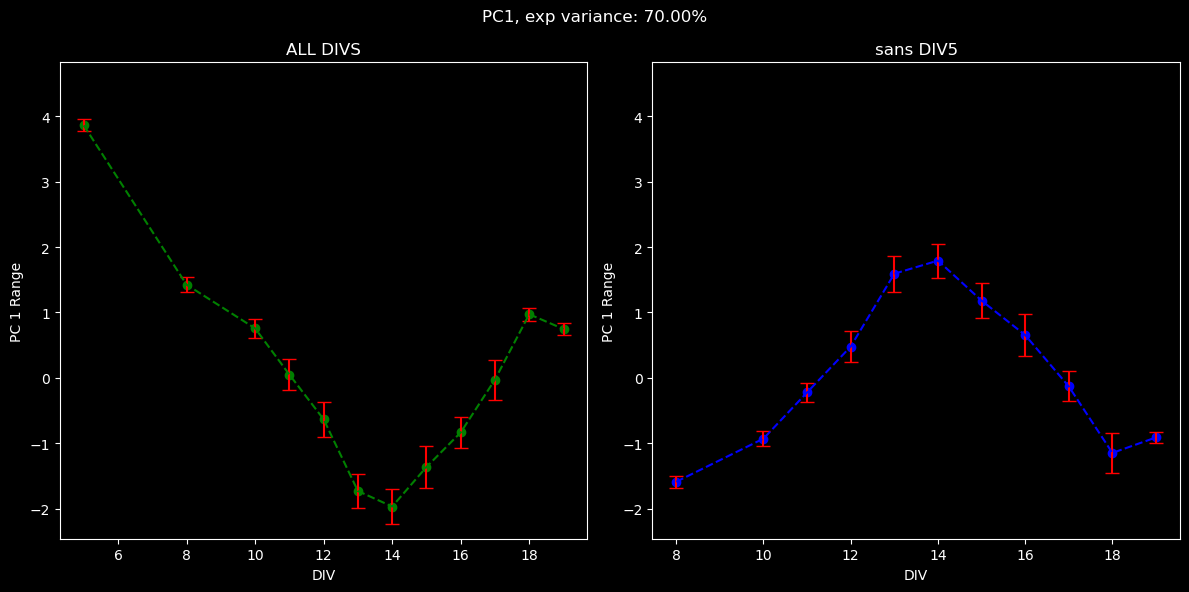

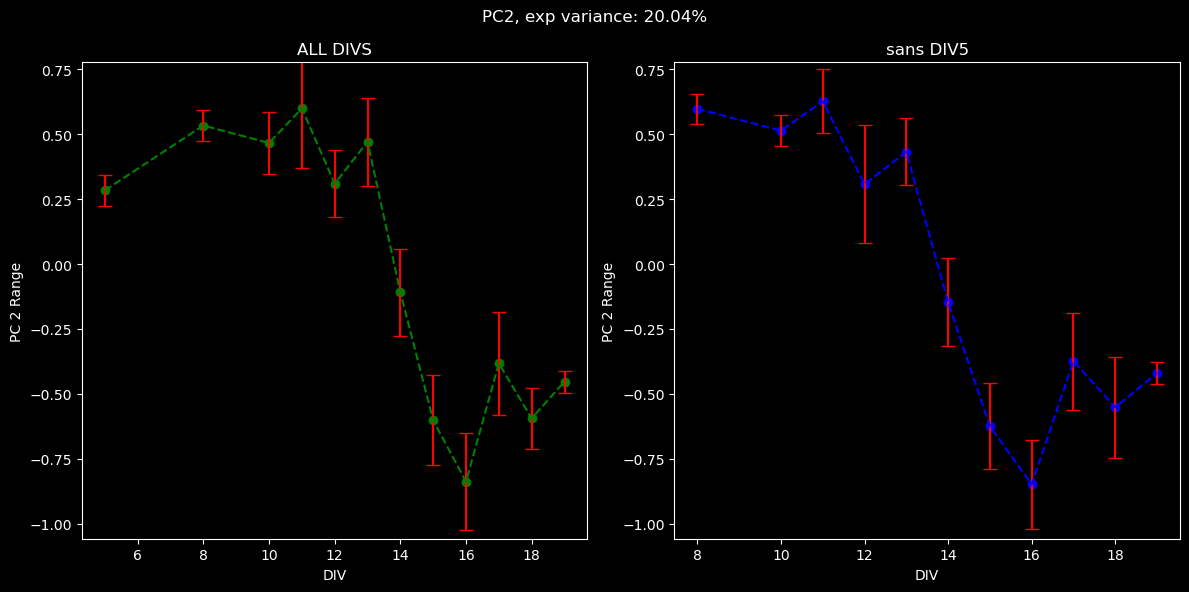

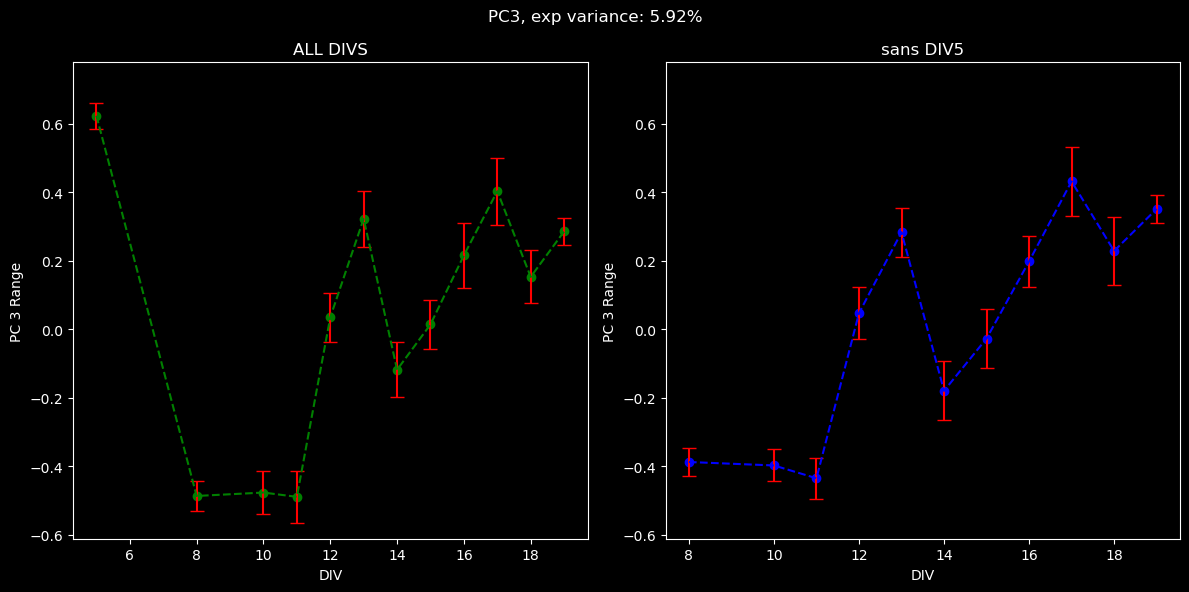

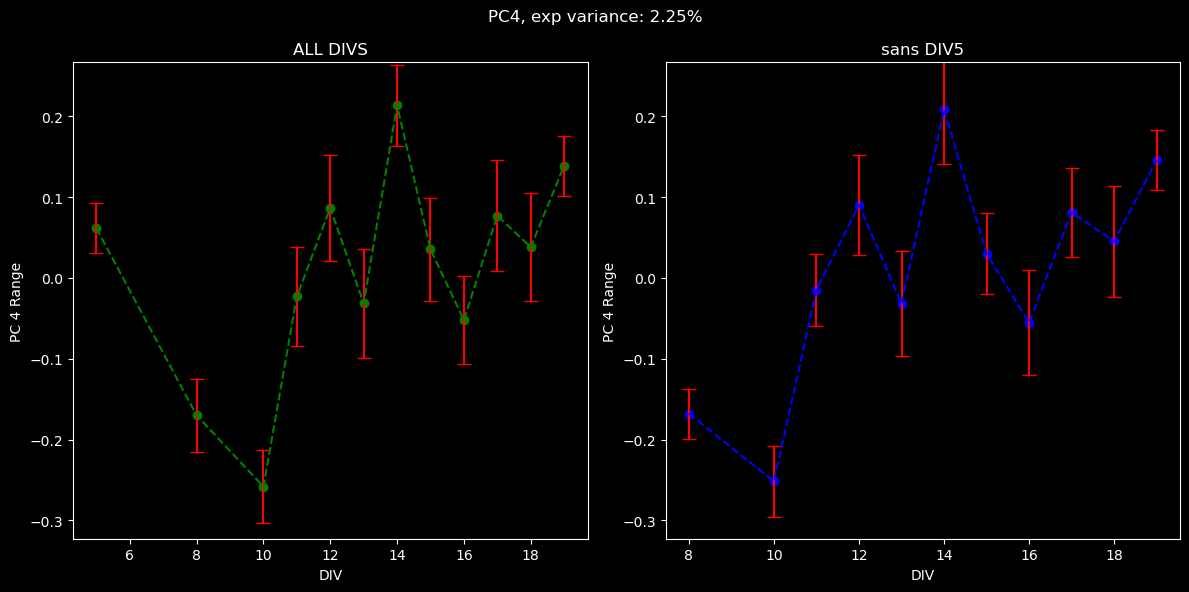

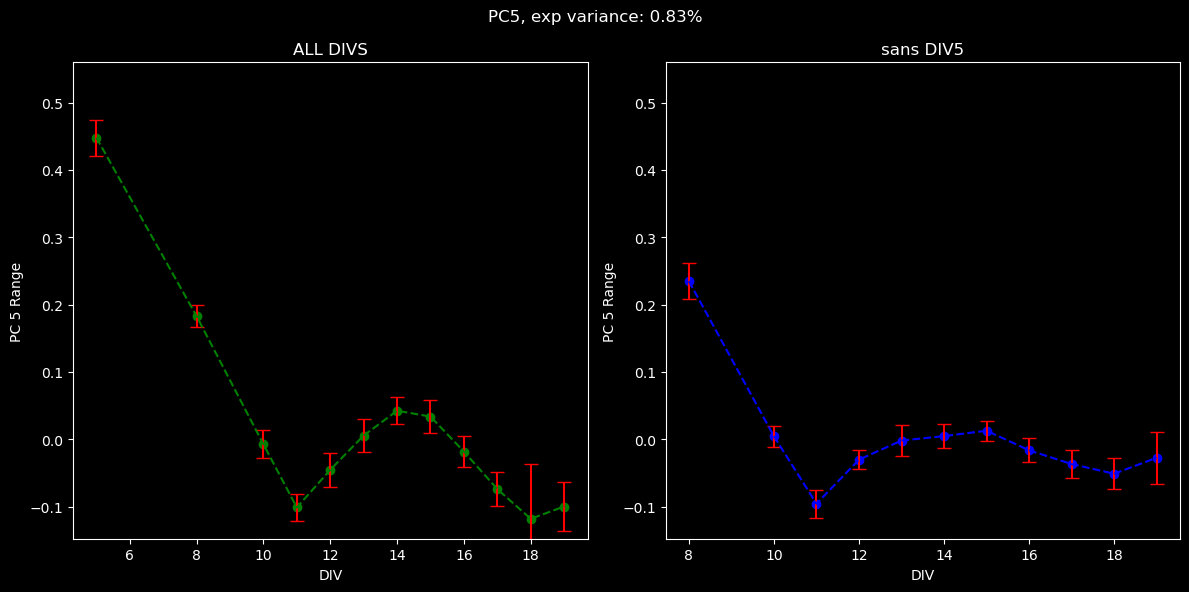

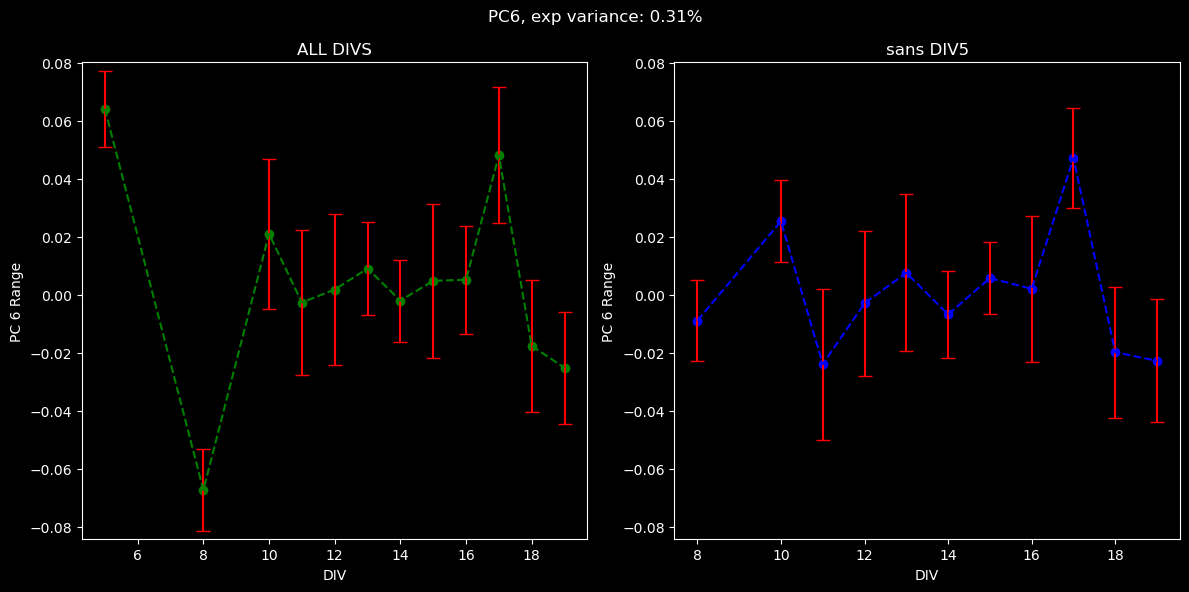

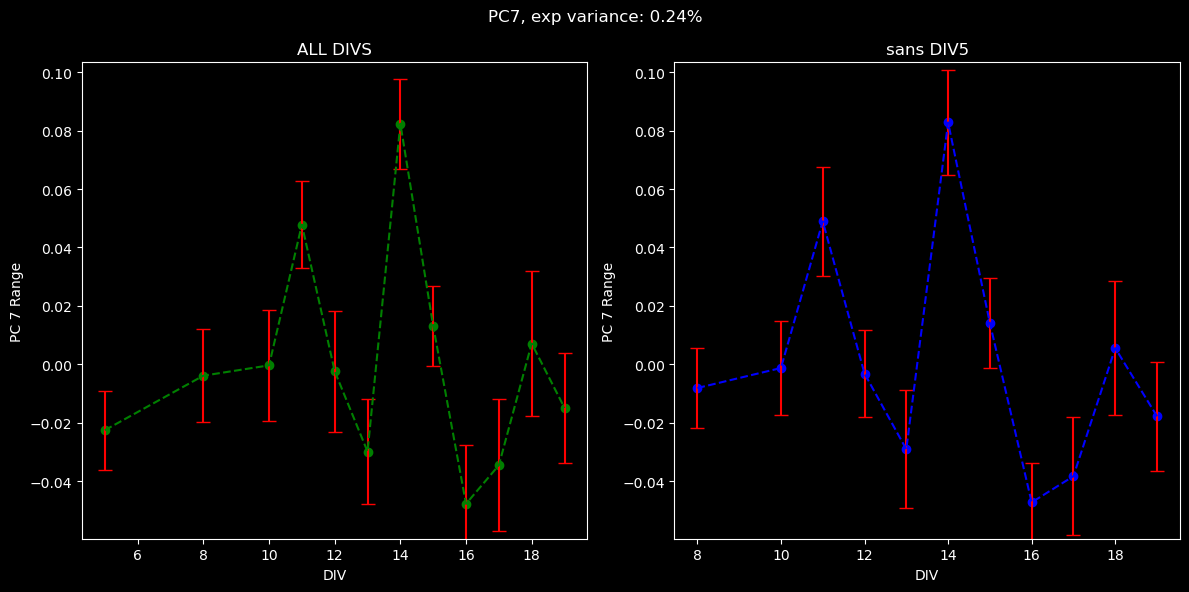

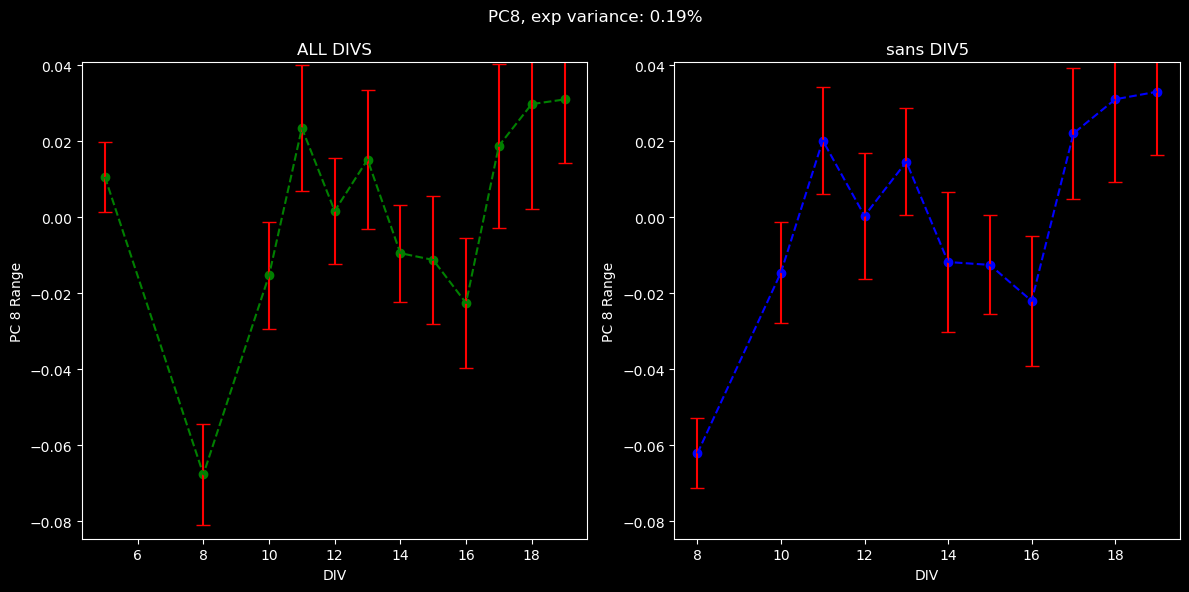

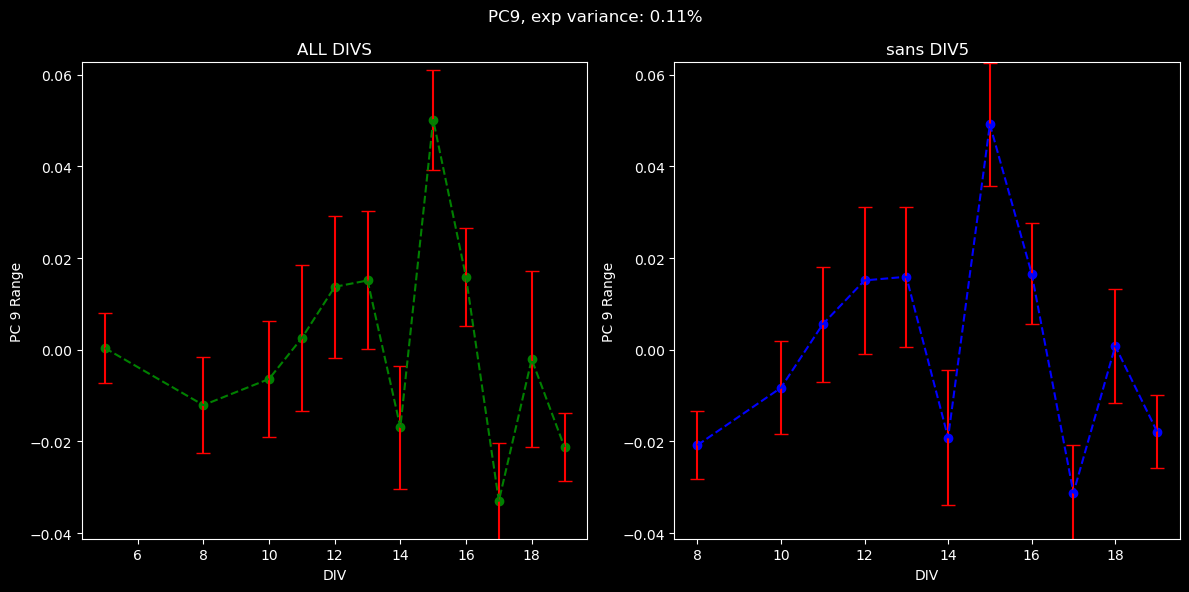

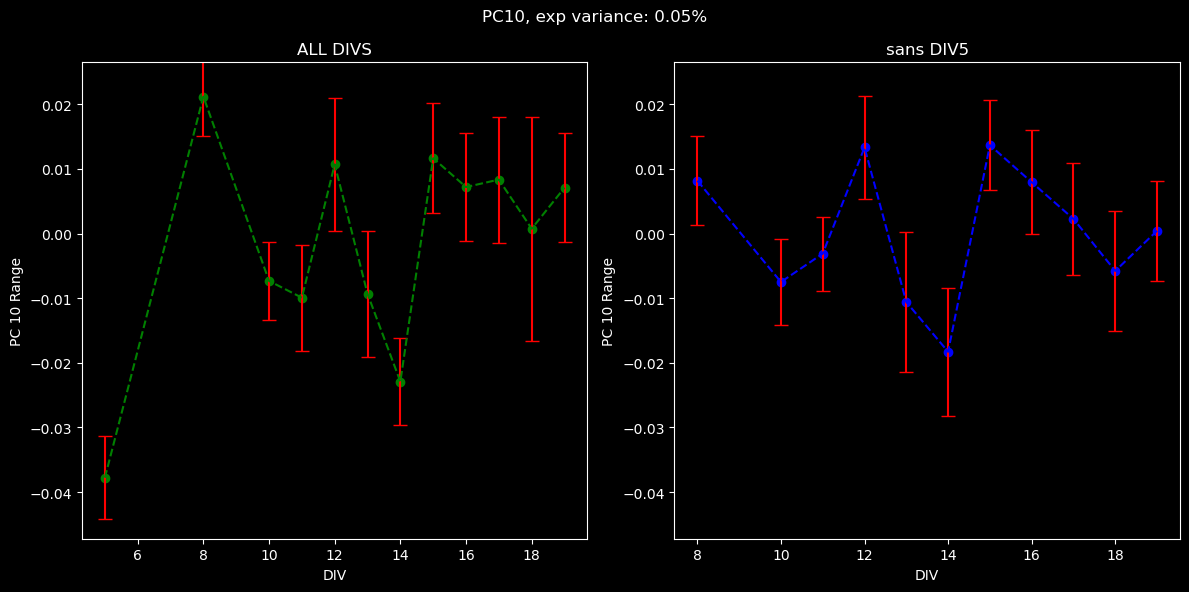

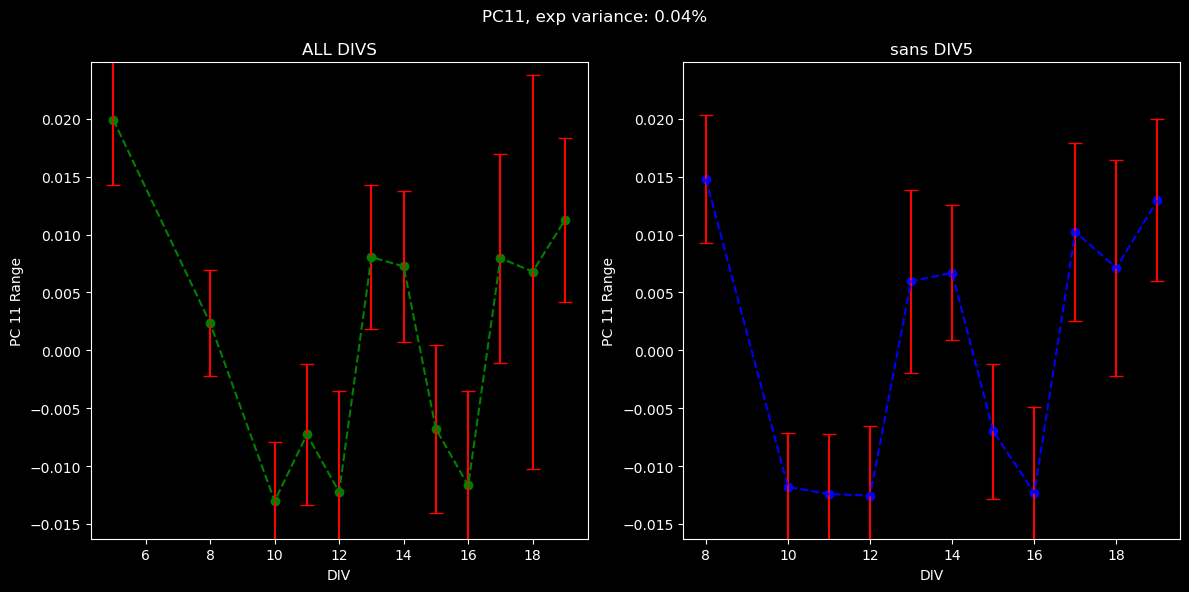

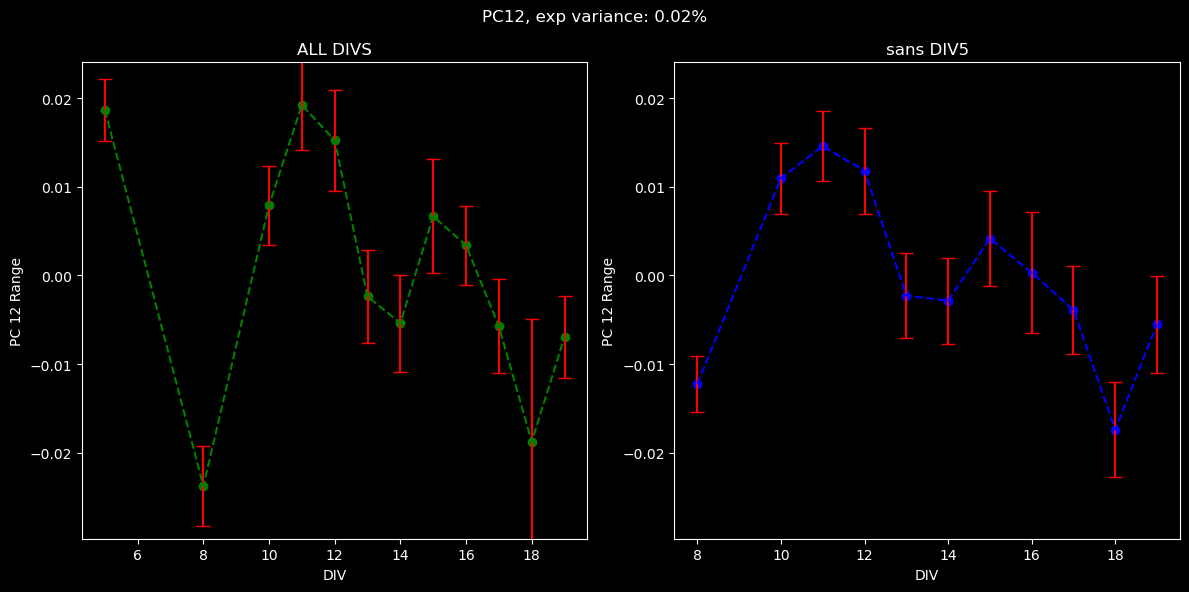

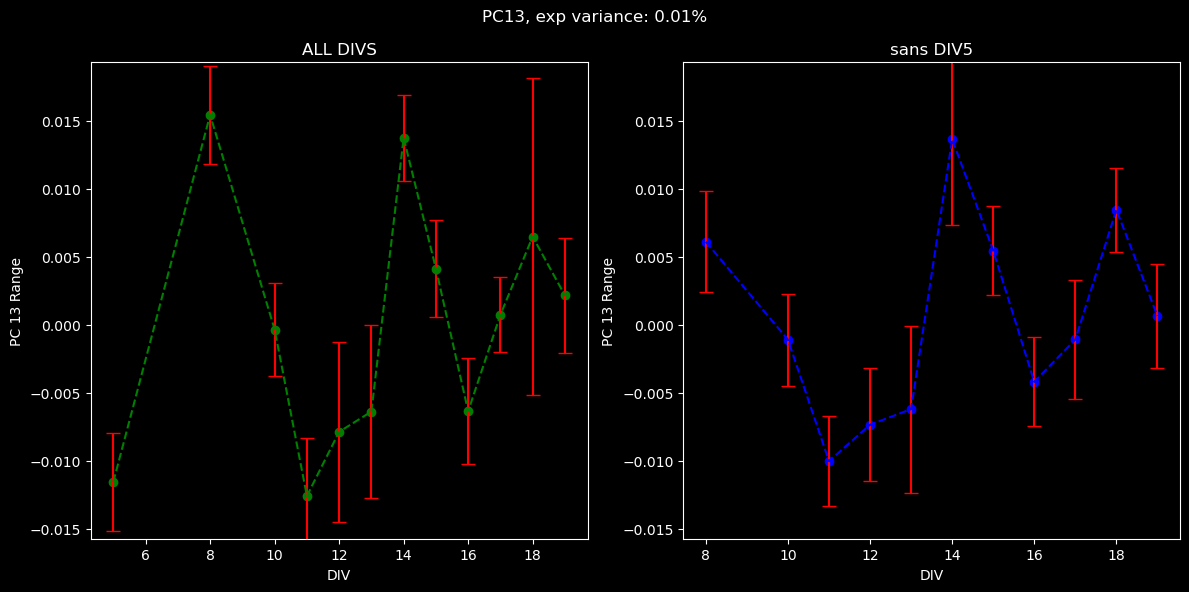

In [67]:
## PC x time 

# Titles for your subplots
titles = ['ALL DIVS', 'sans DIV5']

colors = ['green', 'blue']
for k, col in enumerate(norm_sf.columns):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f'PC{k+1}, exp variance: {exp_variance[f"PC{k+1}"]*100:.2f}%')
    
    gmin, gmax = 0,0
    for (DATA, DIV_INDEX, ax, title, color) in (zip([norm_sf, norm_sf5], [DIVS_SF, DIVS_SF5], axes, titles, colors)):
        pca = PCA(n_components=DATA.shape[1])
        principalComponent = pca.fit_transform(DATA)
        pca_df = pd.DataFrame(data=principalComponent, columns=[f'PC{i}' for i in range(1, DATA.shape[1]+1)])
        pca_df['DIV'] = DIV_INDEX

        pca_avg = pca_df.groupby('DIV', as_index=True).mean()
        pca_sem = pca_df.groupby('DIV', as_index=True).sem()
        # pca_avg.set_index('DIV', inplace=True)
        pca_avg = pca_avg.set_index(pca_avg.index.map(custom_sort)).sort_index()
        assert(pca_avg.shape[-1] == DATA.shape[-1])
        ax.scatter(pca_avg.index, pca_avg.iloc[:, k], color=color) 
        ax.errorbar(pca_avg.index, pca_avg.iloc[:, k], ecolor='red',yerr=pca_sem.iloc[:, k], linestyle='--', color=color, capsize=5)
        ax.set_title(f"{title}")
        ax.set_xlabel('DIV')
        gmin = min(pca_avg.iloc[:, k].min(), gmin) - (0.25*np.abs(gmin))
        gmax = max(pca_avg.iloc[:, k].max(), gmax) + (0.25*gmax)
        
        ax.set_ylabel(f'PC {k+1} Range')
        
    for ax in axes:
        ax.set_ylim(gmin, gmax)
    plt.tight_layout()
    SAVE_FILE = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/PCtime/NEW/'\
                    f'PC{k+1}.png'
    ensure_dirs_exists(SAVE_FILE)
    plt.savefig(SAVE_FILE)
    plt.show()